# Hyper Parameter Optimization For K-Nearest Neighbor

In [29]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'KNN'

In [30]:
current_path = os.getcwd()
current_path

'/output/workspace/Band-gap-predict/SingleModels/KNN'

In [31]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [32]:
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [33]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [7]:
# using random search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimization begin...")

# create an model
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])
# define the parameter distributions  for the KNN model
# total 
param_distributions = {
    'knn__n_neighbors': list(np.arange(3, 100, 8)) + [11, 21, 51, 71],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],  
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# create a randomized search CV object
# using n_iter=100 for a faster search, you can increase this for better results
# forget to assign metrics score, the default is R2 score
random_search = RandomizedSearchCV(estimator=knn_pipe, param_distributions=param_distributions,
                n_iter=100, cv=kf, verbose=1, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
random_search.fit(dft_train_X, dft_train_y)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn',
                                              KNeighborsRegressor(n_jobs=-1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan',
                                                        'chebyshev',
                                                        'minkowski'],
                                        'knn__n_neighbors': [np.int64(3),
                                                             np.int64(11),
                                                             np.int64(19),
                                                             np.int64(27),
                                                             np.int64(35),
                                                             np.int64(43),
                                                             np.int64(51),
                                                             np.int64(59),
                                                             np.int64(67),
                                                             np.int64(75),
                                                             np.int64(83),
                                                             np.int64(91),
                                                             np.int64(99), 11,
                                                             21, 51, 71],
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_knn__n_neighbors', 
                               'param_knn__weights', 'param_knn__p', 'param_knn__metric',
                               'train_rmse', 'test_rmse']] 
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'dft_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': np.int64(11), 'knn__metric': 'minkowski'}
Best Cross-Validation RMSE: 0.8342


rank_test_score  param_knn__n_neighbors param_knn__weights  param_knn__p  \
6                 1                      11           distance             1   
61                1                      11           distance             2   
69                1                      11           distance             1   
44                4                      19           distance             1   
2                 4                      19           distance             2   

   param_knn__metric  train_rmse  test_rmse  
6          minkowski    0.132397   0.834222  
61         manhattan    0.132397   0.834222  
69         manhattan    0.132397   0.834222  
44         manhattan    0.132396   0.842059  
2          manhattan    0.132396   0.842059

### Overfitting check

####################################################################################################
[DFT - KNN] Training KNN on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train_error] Evaluating DFT KNN on DFT train set:


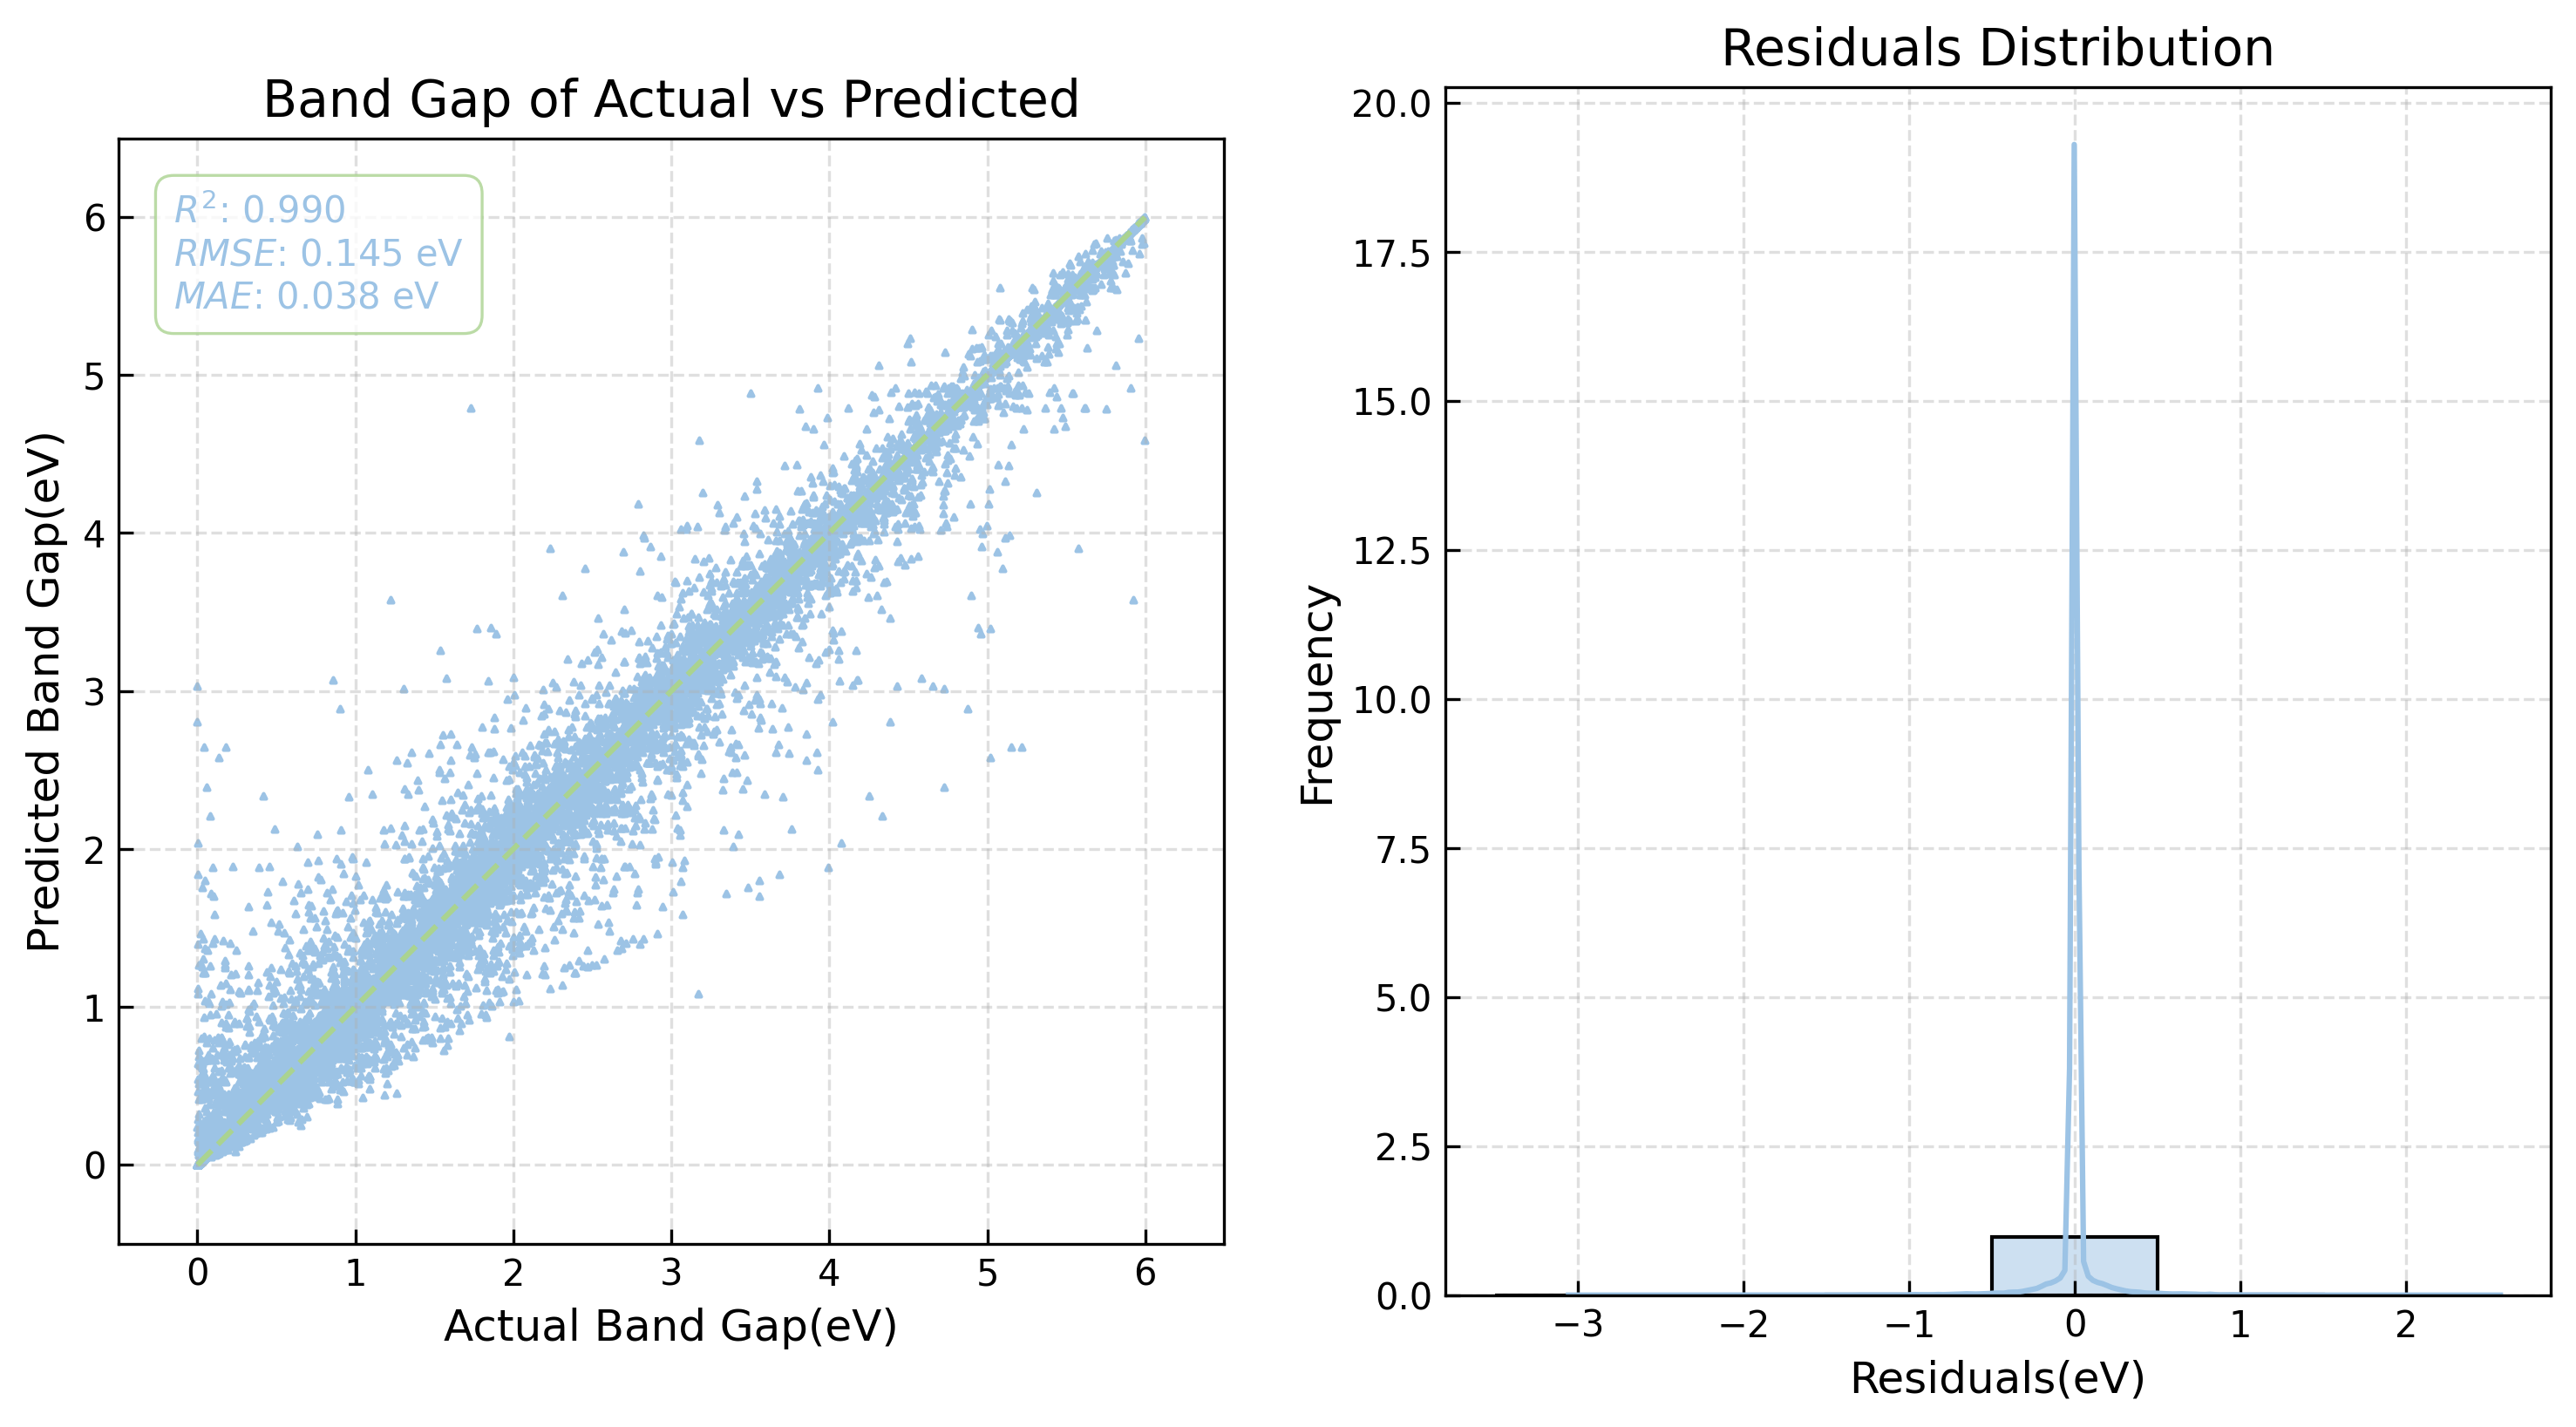


Model Evaluation Results:
Test set: R²: 0.9903 RMSE: 0.1455 MAE: 0.0377
[Test DFT -> DFT] Evaluating DFT KNN on DFT test set:


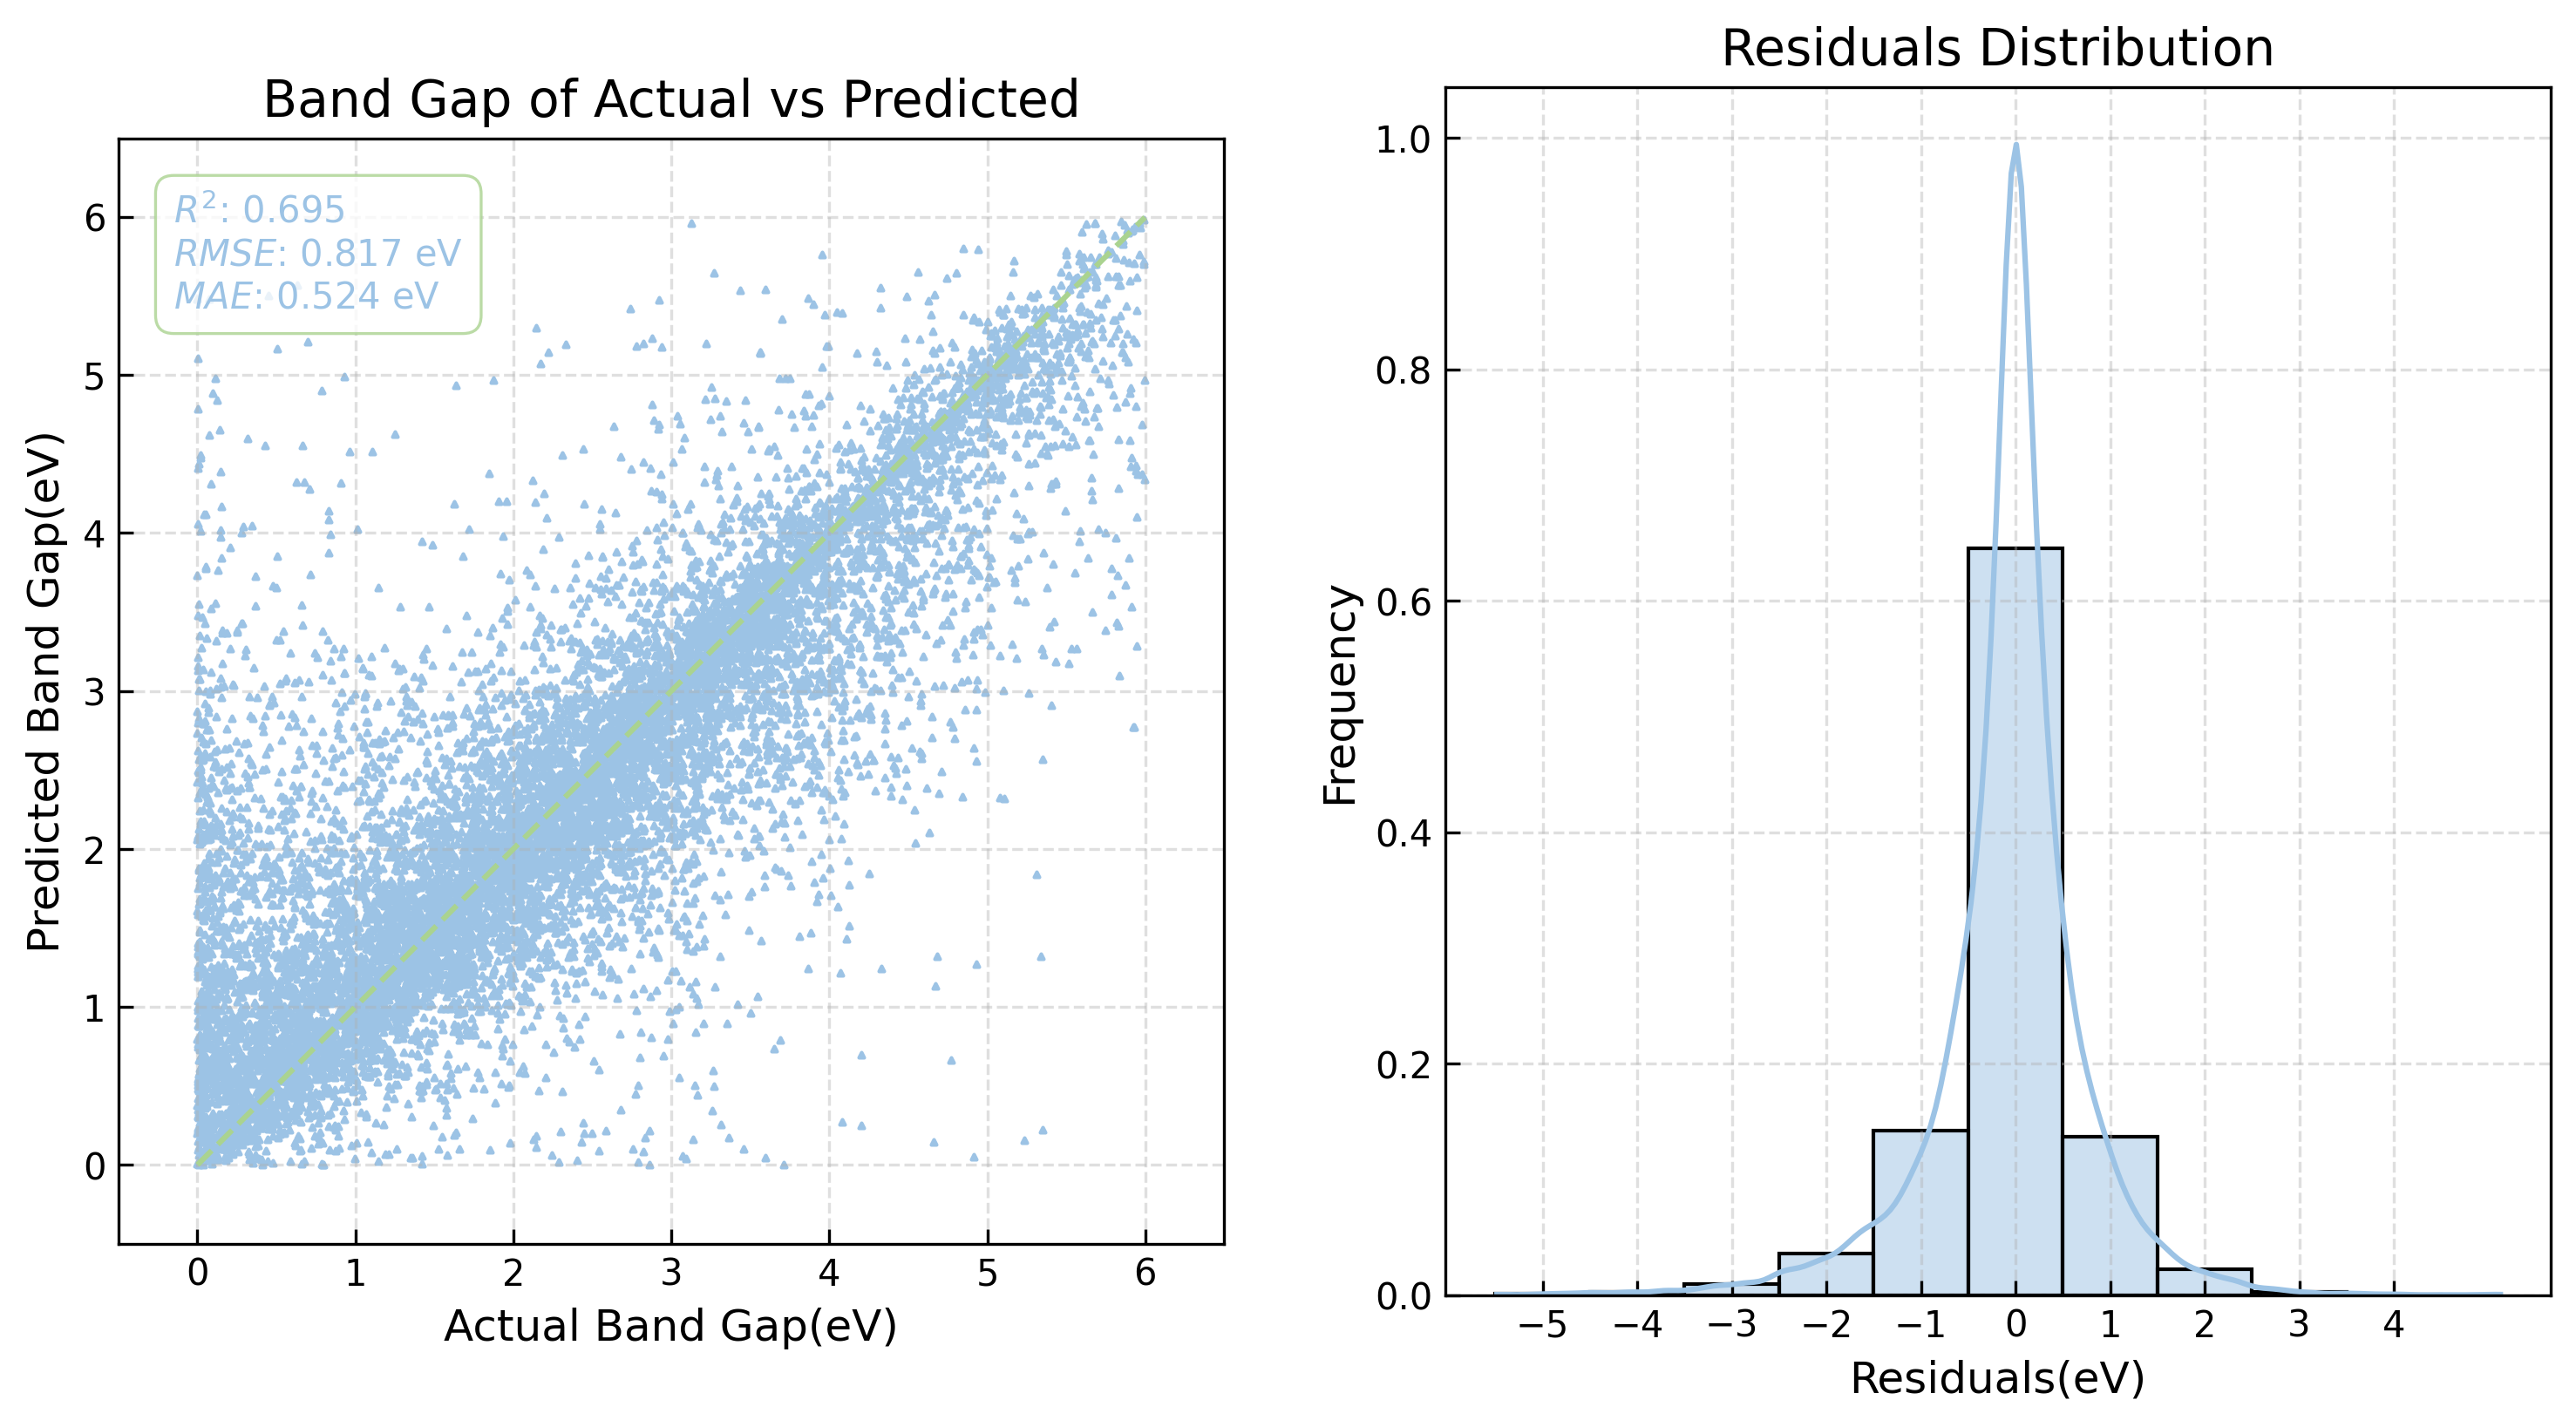


Model Evaluation Results:
Test set: R²: 0.6948 RMSE: 0.8166 MAE: 0.5241
[Test DFT -> EXP] Evaluating DFT KNN on EXP test set:


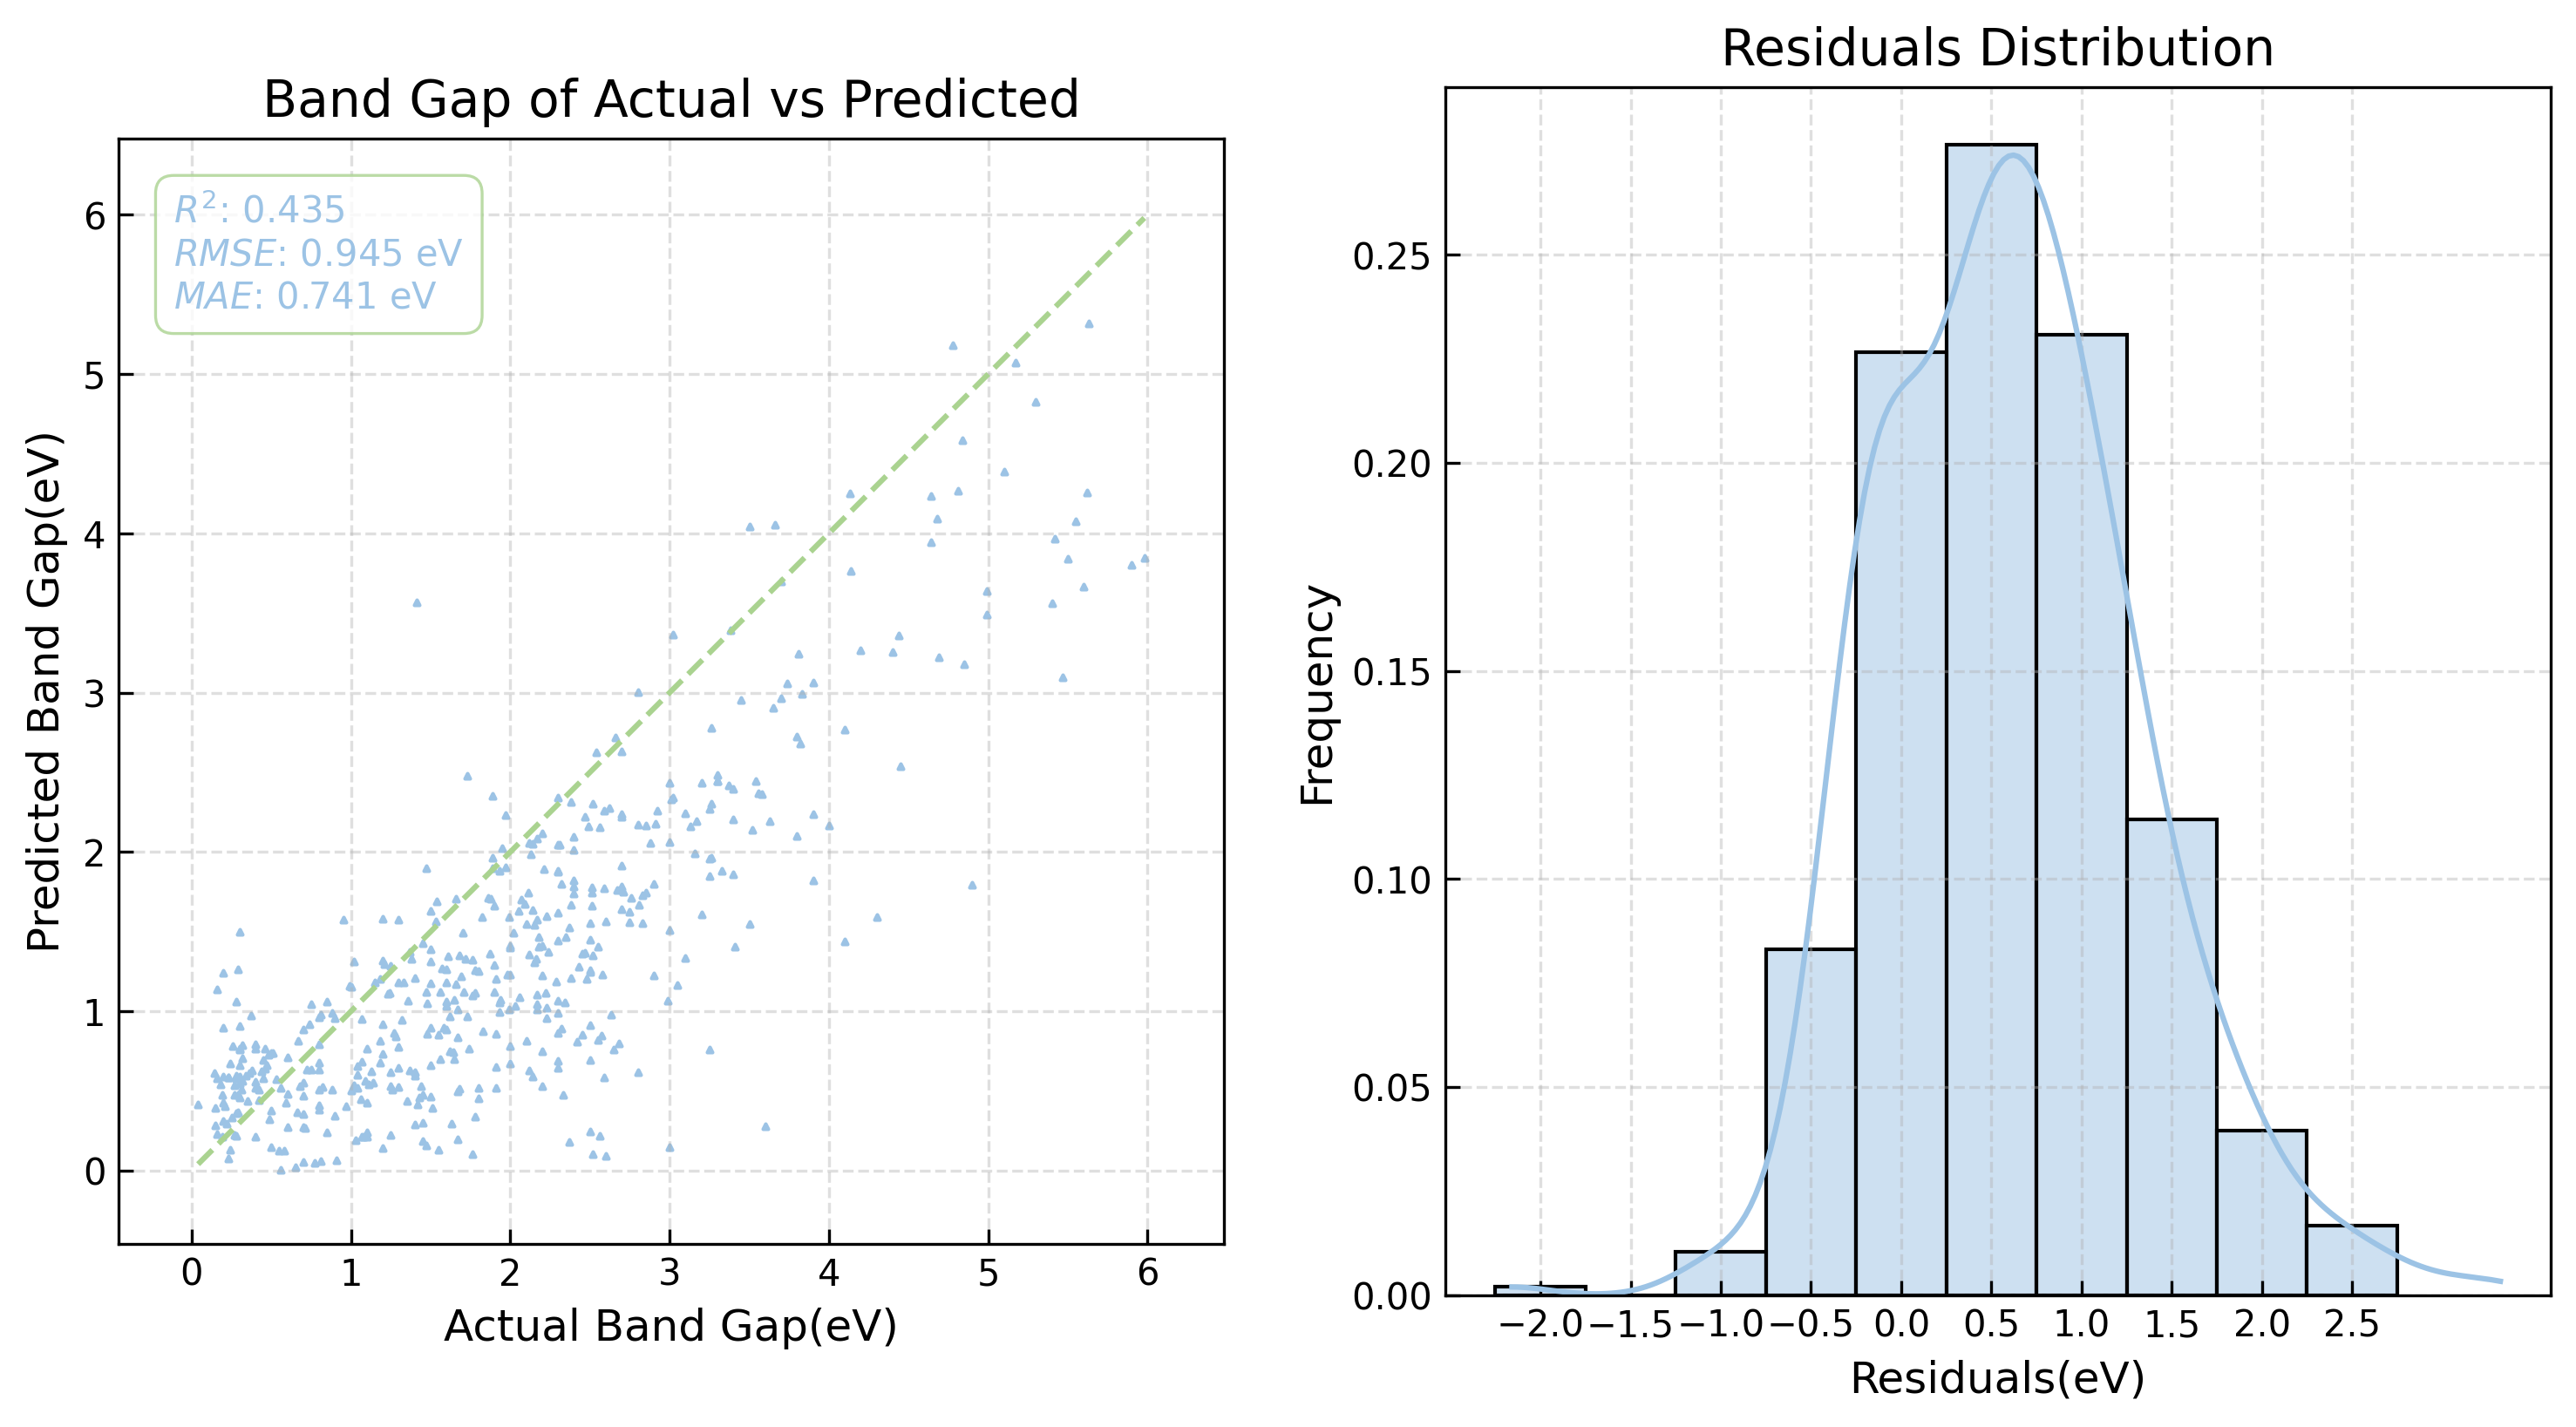


Model Evaluation Results:
Test set: R²: 0.4350 RMSE: 0.9446 MAE: 0.7415


In [11]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
knn_best = KNeighborsRegressor(n_neighbors=11, weights='distance', metric='minkowski', p=1, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(knn_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [12]:
model_metrics.head()

Model Error_Type Train_set Test_set        R²      RMSE       MAE
0   KNN      Train       dft      dft  0.990293  0.145485  0.037682
1   KNN       Test       dft      dft  0.694822  0.816563  0.524149
2   KNN       Test       dft      exp  0.435033  0.944575  0.741490

### EXP Model

In [34]:
# using random search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimization begin...")

# create an model
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])

# define the parameter distributions  for the KNN model
param_distributions = {
    'knn__n_neighbors': np.arange(3, 100, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2], 
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']     
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


# create a grid search CV object
grid_search = GridSearchCV(estimator=knn_pipe, param_grid=param_distributions,
                cv=kf, verbose=1, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)


['EXP KNN'] HP optimization begin...
Fitting 5 folds for each of 784 candidates, totalling 3920 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'chebyshev',
                                         'minkowski'],
                         'knn__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]),
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [35]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_knn__n_neighbors', 
                               'param_knn__weights', 'param_knn__p', 'param_knn__metric', 
                               'train_rmse', 'test_rmse']] 

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
results_sorted.to_csv(os.path.join(hp_path, 'exp_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': np.int64(5), 'knn__p': 1, 'knn__weights': 'distance'}
Best Cross-Validation RMSE: 0.6413


rank_test_score  param_knn__n_neighbors param_knn__weights  param_knn__p  \
201                1                       5           distance             1   
593                1                       5           distance             1   
203                1                       5           distance             2   
199                4                       3           distance             2   
197                4                       3           distance             1   

    param_knn__metric  train_rmse  test_rmse  
201         manhattan    0.012254   0.641320  
593         minkowski    0.012254   0.641320  
203         manhattan    0.012254   0.641320  
199         manhattan    0.012254   0.646508  
197         manhattan    0.012254   0.646508

### Overfitting check

####################################################################################################
[EXP - KNN] Training KNN on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train_error] Evaluating EXP KNN on EXP train set:


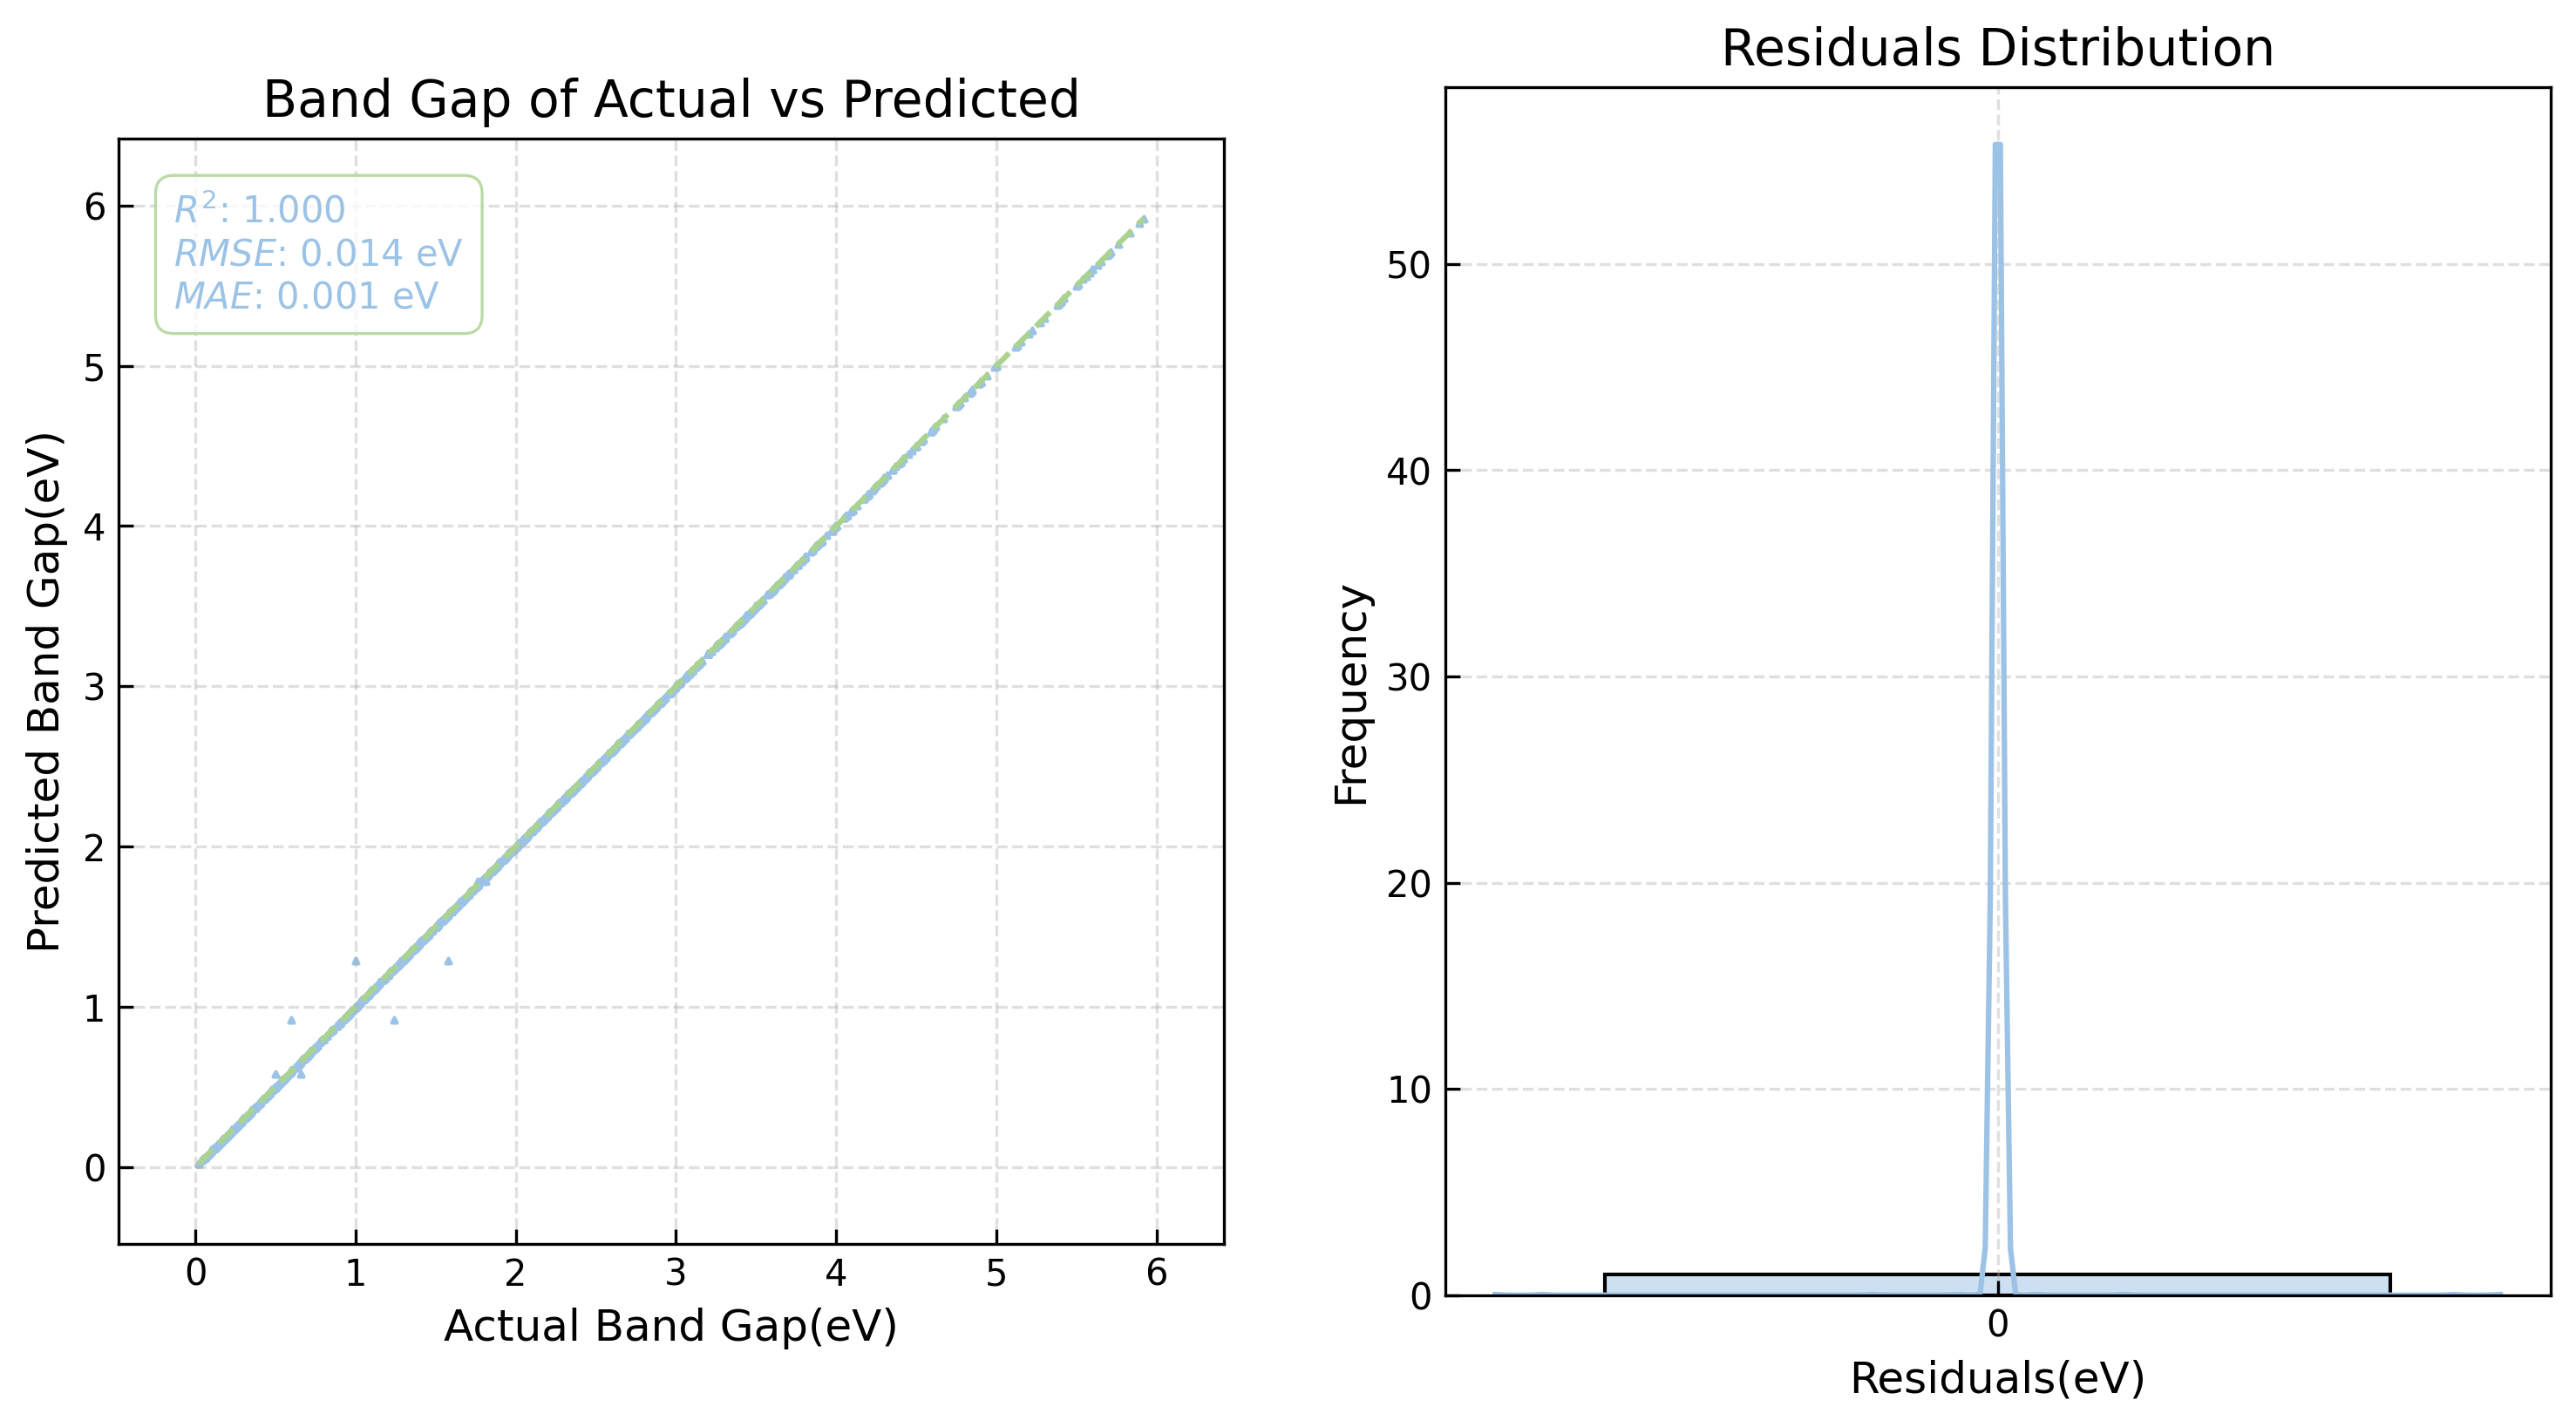


Model Evaluation Results:
Test set: R²: 0.9999 RMSE: 0.0142 MAE: 0.0007
[Test EXP -> EXP] Evaluating EXP KNN on EXP test set:


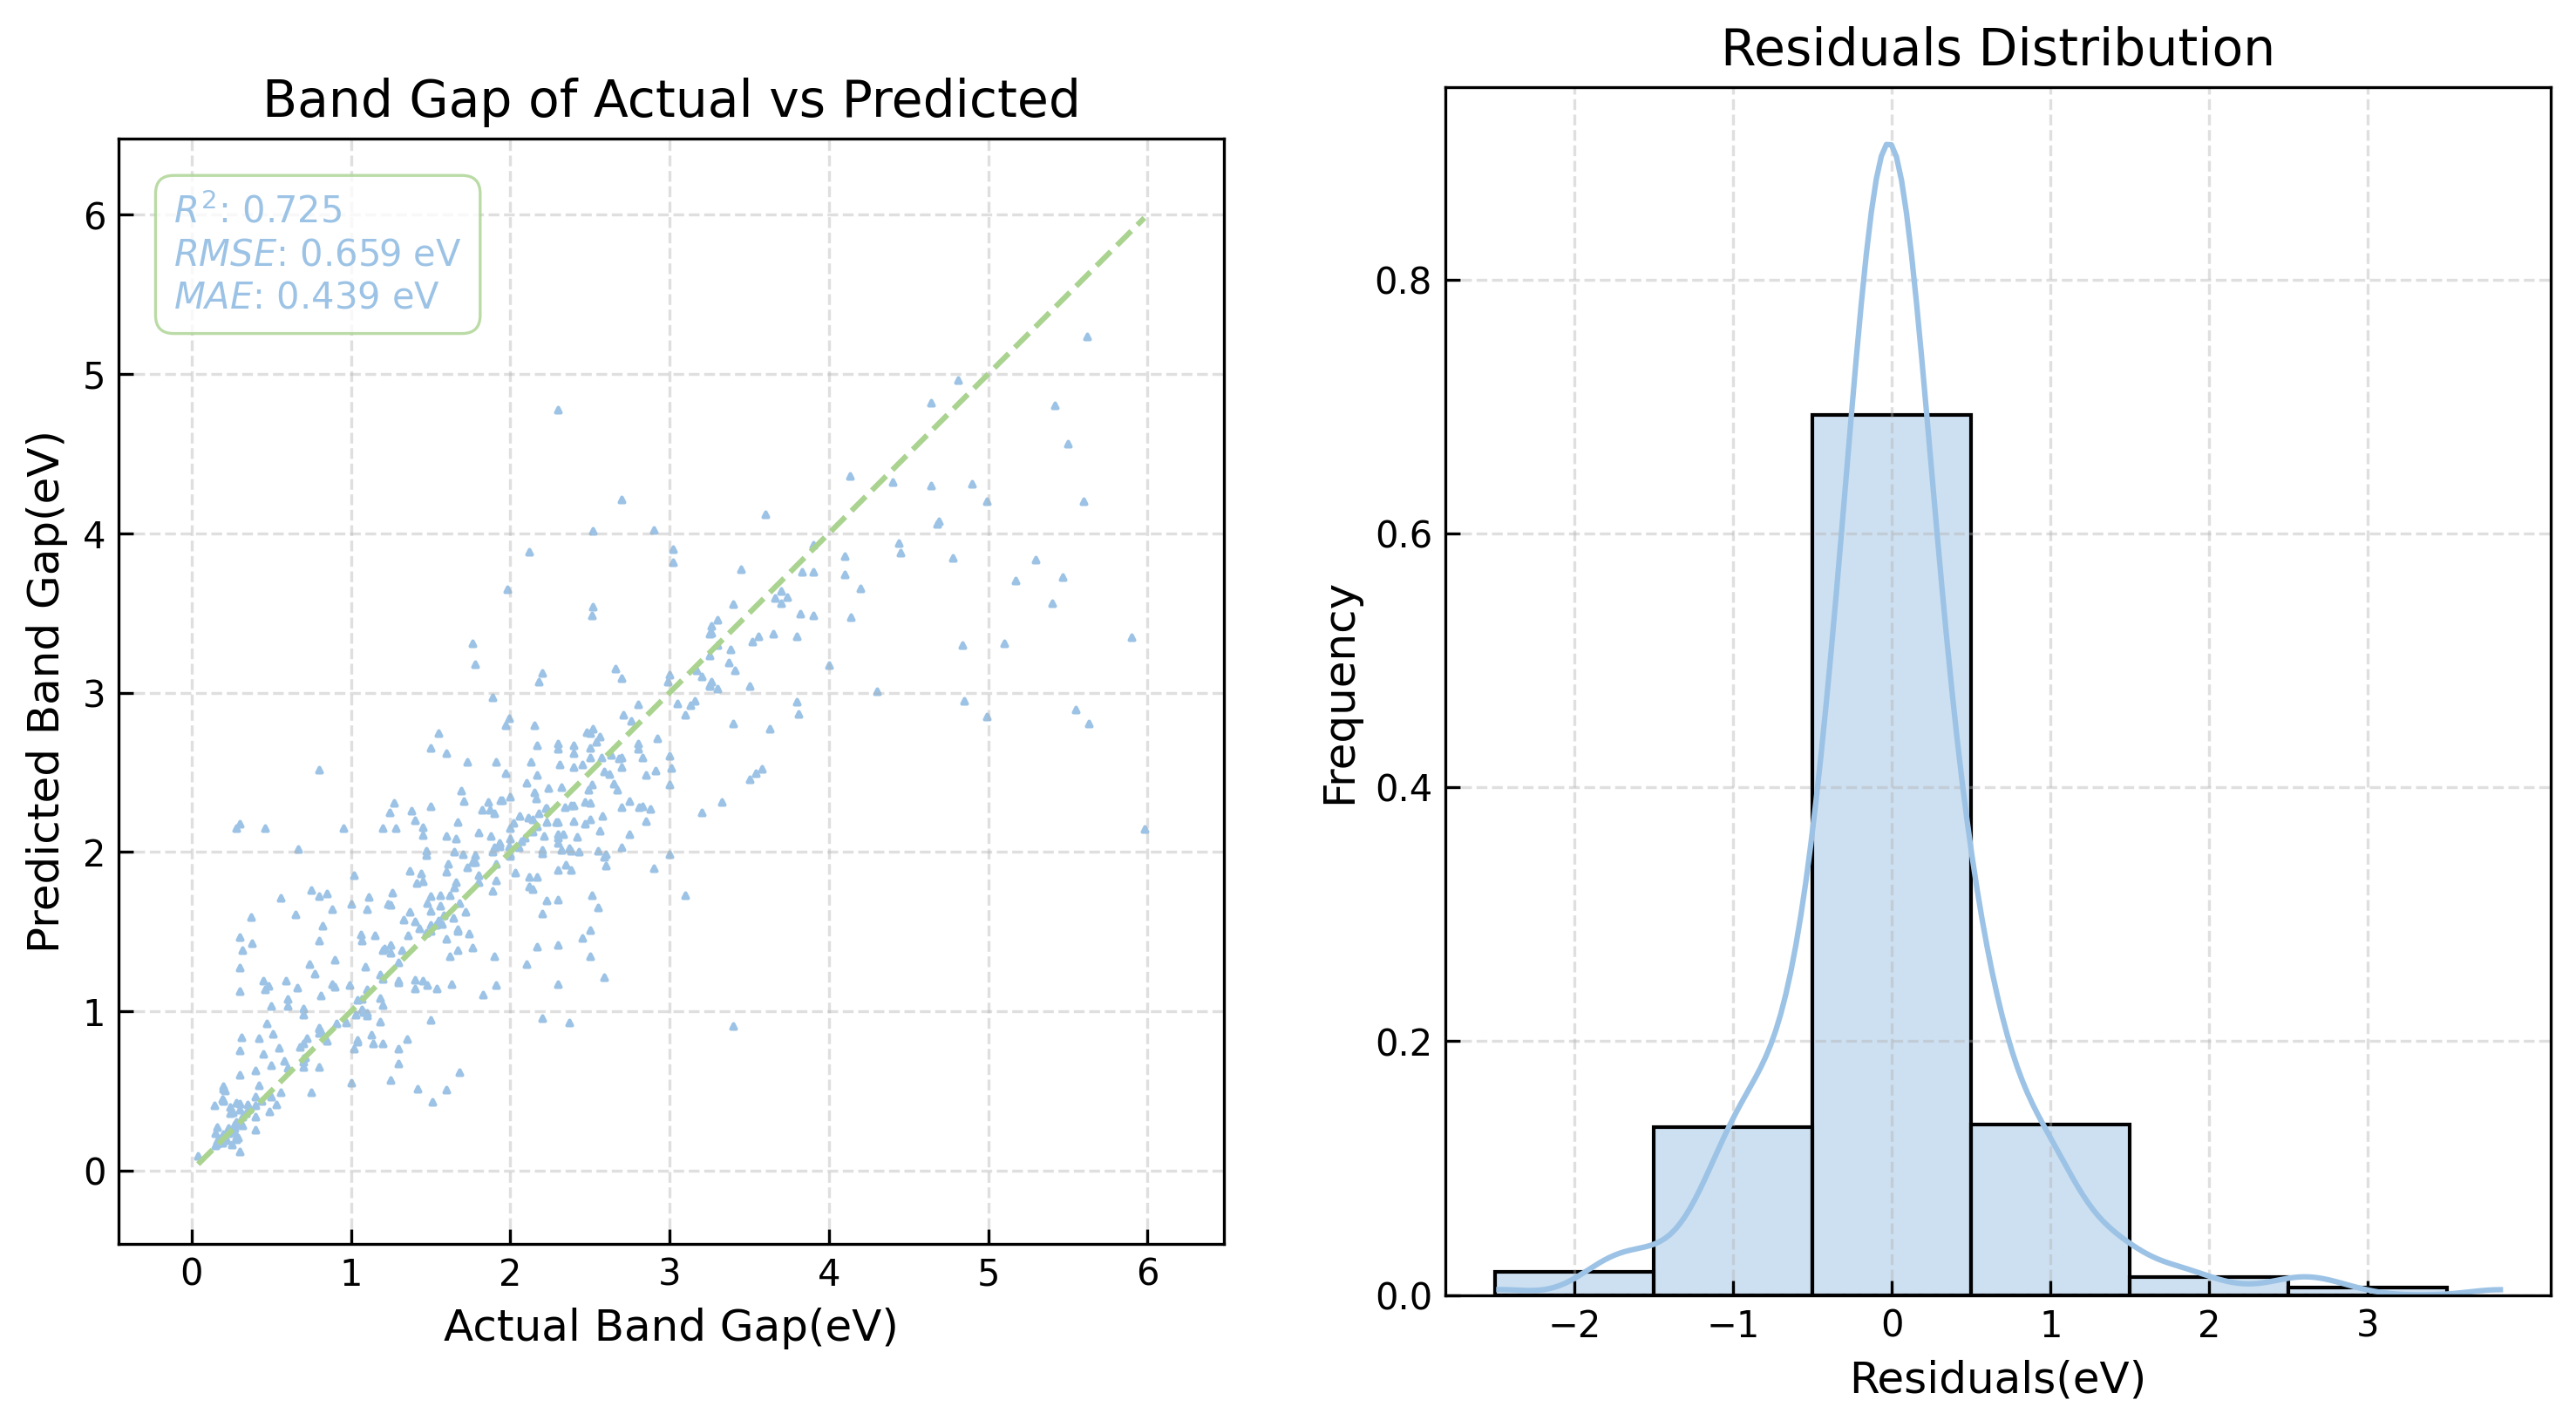


Model Evaluation Results:
Test set: R²: 0.7248 RMSE: 0.6593 MAE: 0.4388
[Test EXP -> DFT] Evaluating EXP KNN on DFT test set:


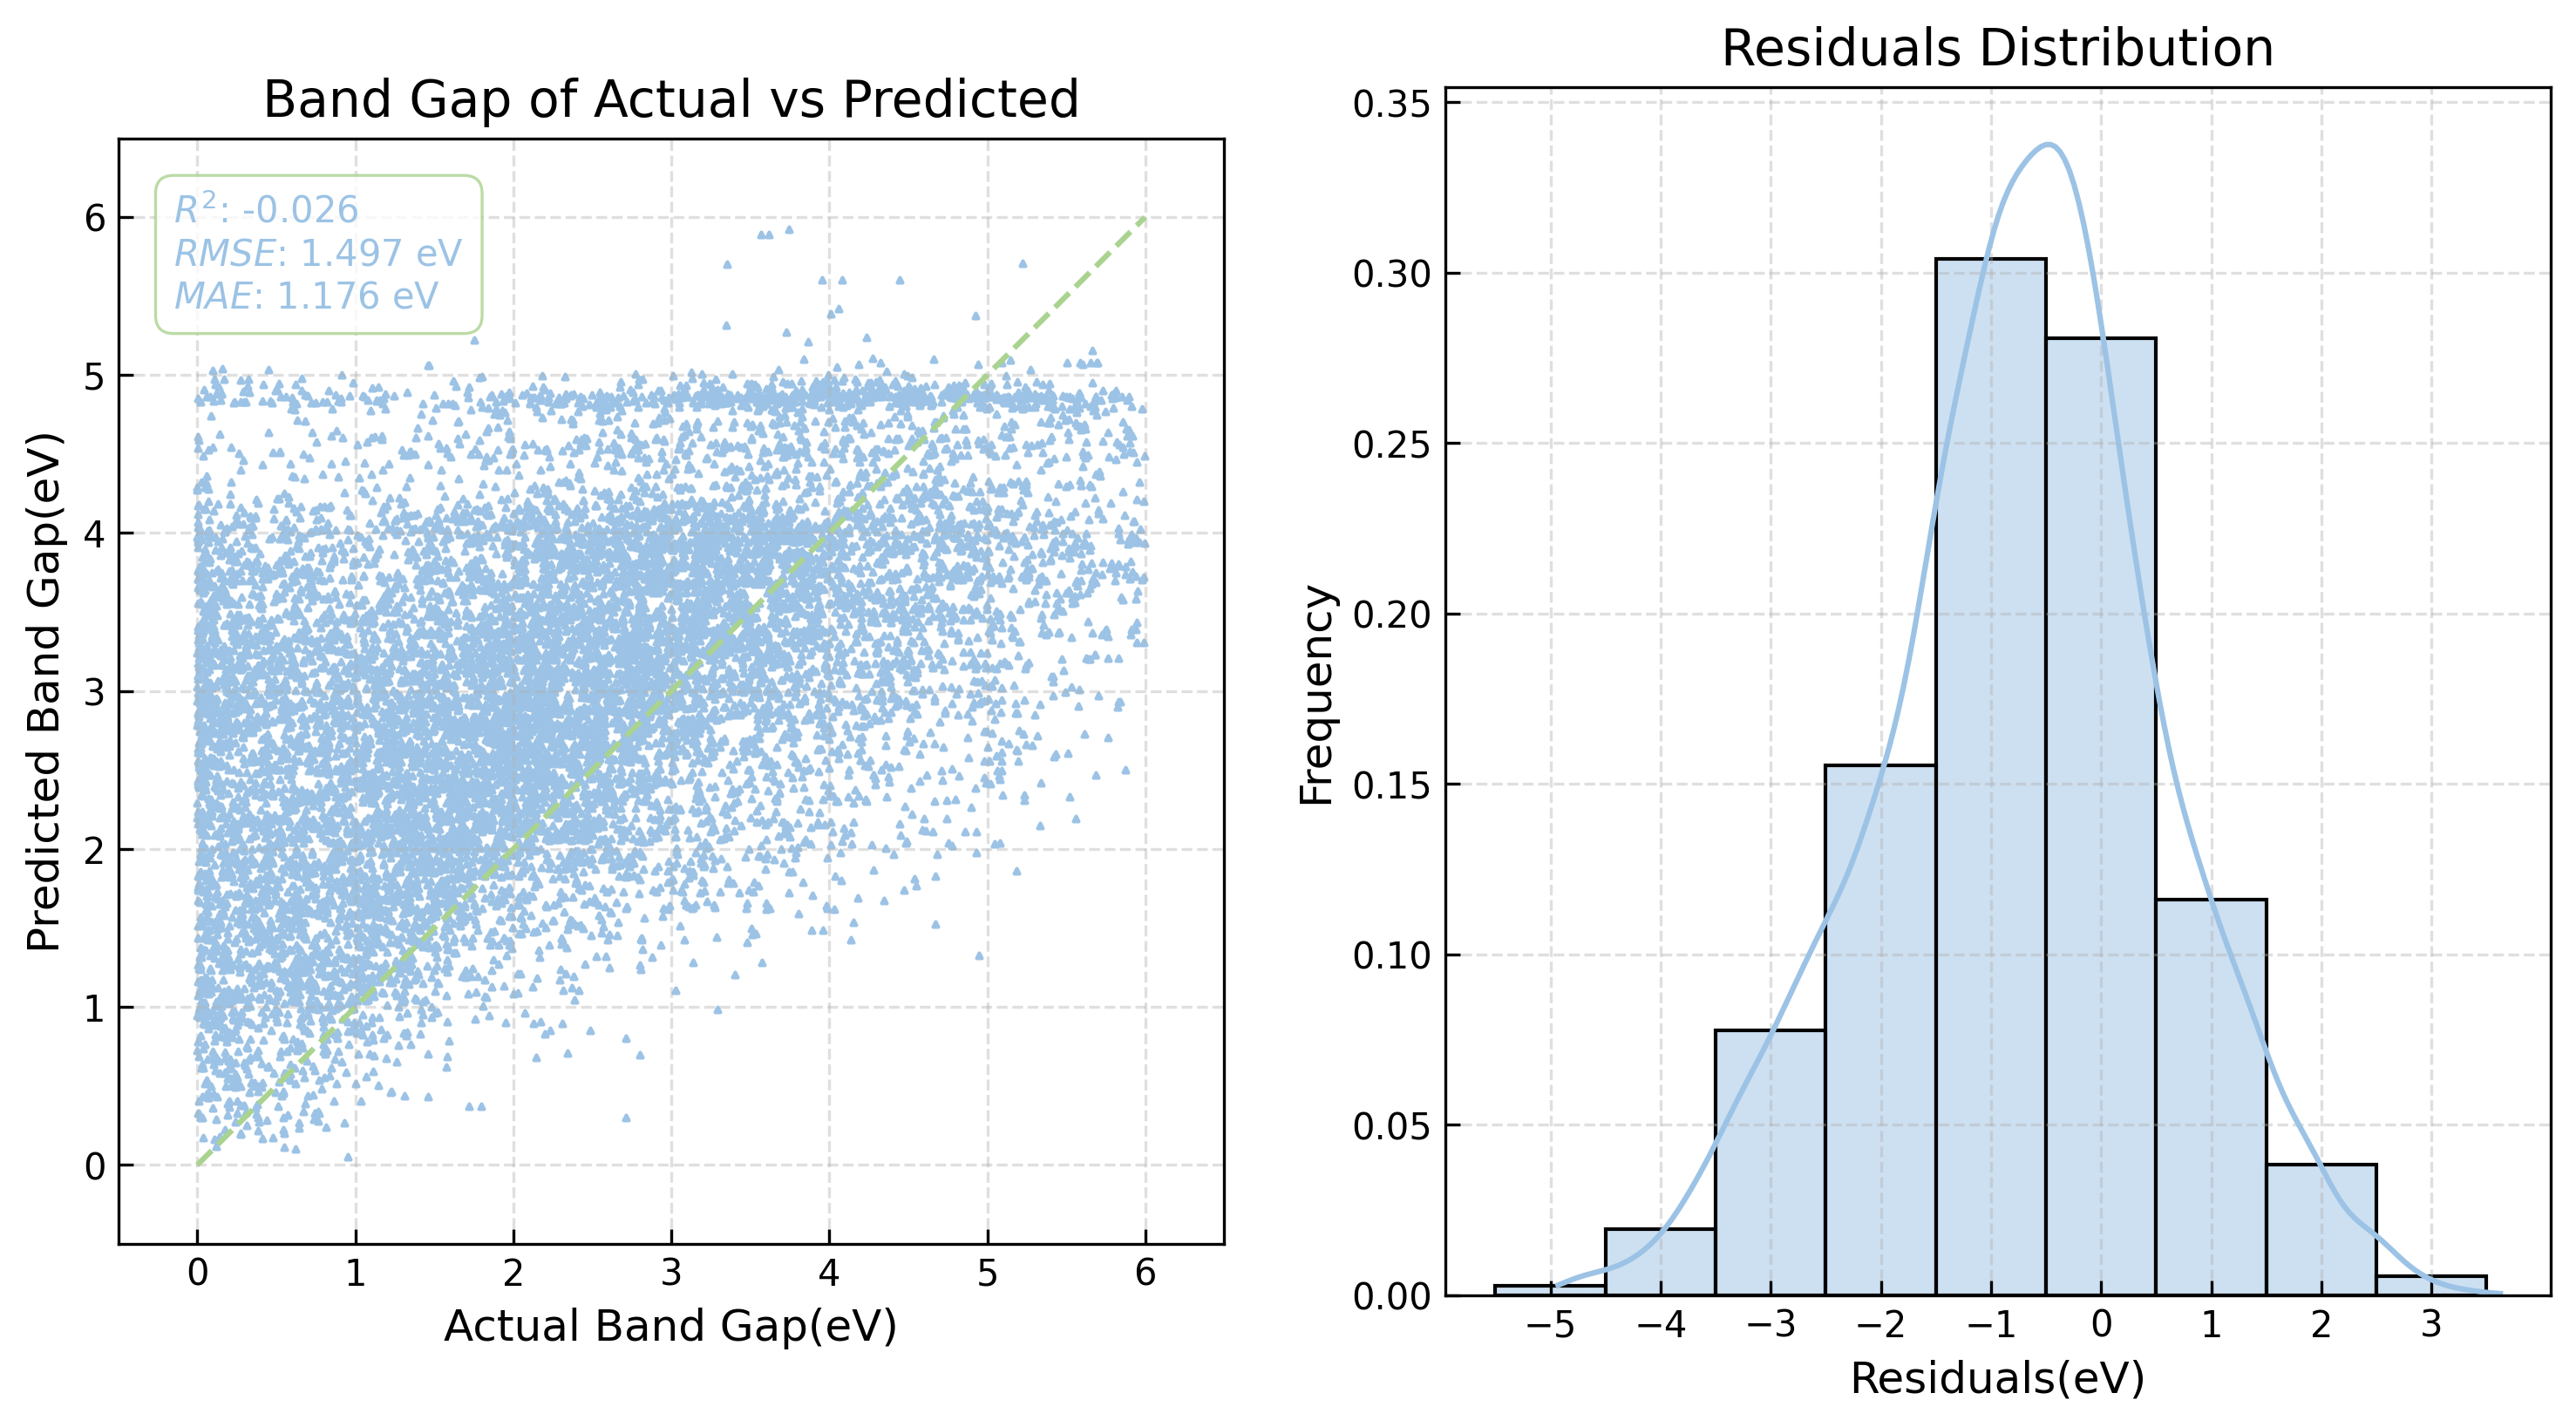


Model Evaluation Results:
Test set: R²: -0.0256 RMSE: 1.4969 MAE: 1.1758


In [36]:

# 
# Train the model with the best hyperparameters on the entire training set
knn_best = KNeighborsRegressor(n_neighbors=5, weights='distance', p=1, metric='manhattan', n_jobs=-1)

# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(knn_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [37]:
model_metrics.head()

Model Error_Type Train_set Test_set        R²      RMSE       MAE
0   KNN      Train       exp      exp  0.999864  0.014150  0.000740
1   KNN       Test       exp      exp  0.724763  0.659292  0.438762
2   KNN       Test       exp      dft -0.025614  1.496941  1.175752

- a very serious overfitting of KNN when we use the weights='distanve' in the best parameter of random searched
- to decrease overfitting problem, we try to use the weights='uniform'

In [38]:
results_sorted[results_sorted['param_knn__weights'] == 'uniform'].head()

rank_test_score  param_knn__n_neighbors param_knn__weights  param_knn__p  \
196               22                       3            uniform             1   
588               22                       3            uniform             1   
198               22                       3            uniform             2   
592               28                       5            uniform             1   
202               28                       5            uniform             2   

    param_knn__metric  train_rmse  test_rmse  
196         manhattan    0.454789   0.676379  
588         minkowski    0.454789   0.676379  
198         manhattan    0.454789   0.676379  
592         minkowski    0.535981   0.682016  
202         manhattan    0.535981   0.682016

####################################################################################################
[EXP - KNN] Training KNN on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train_error] Evaluating EXP KNN on EXP train set:


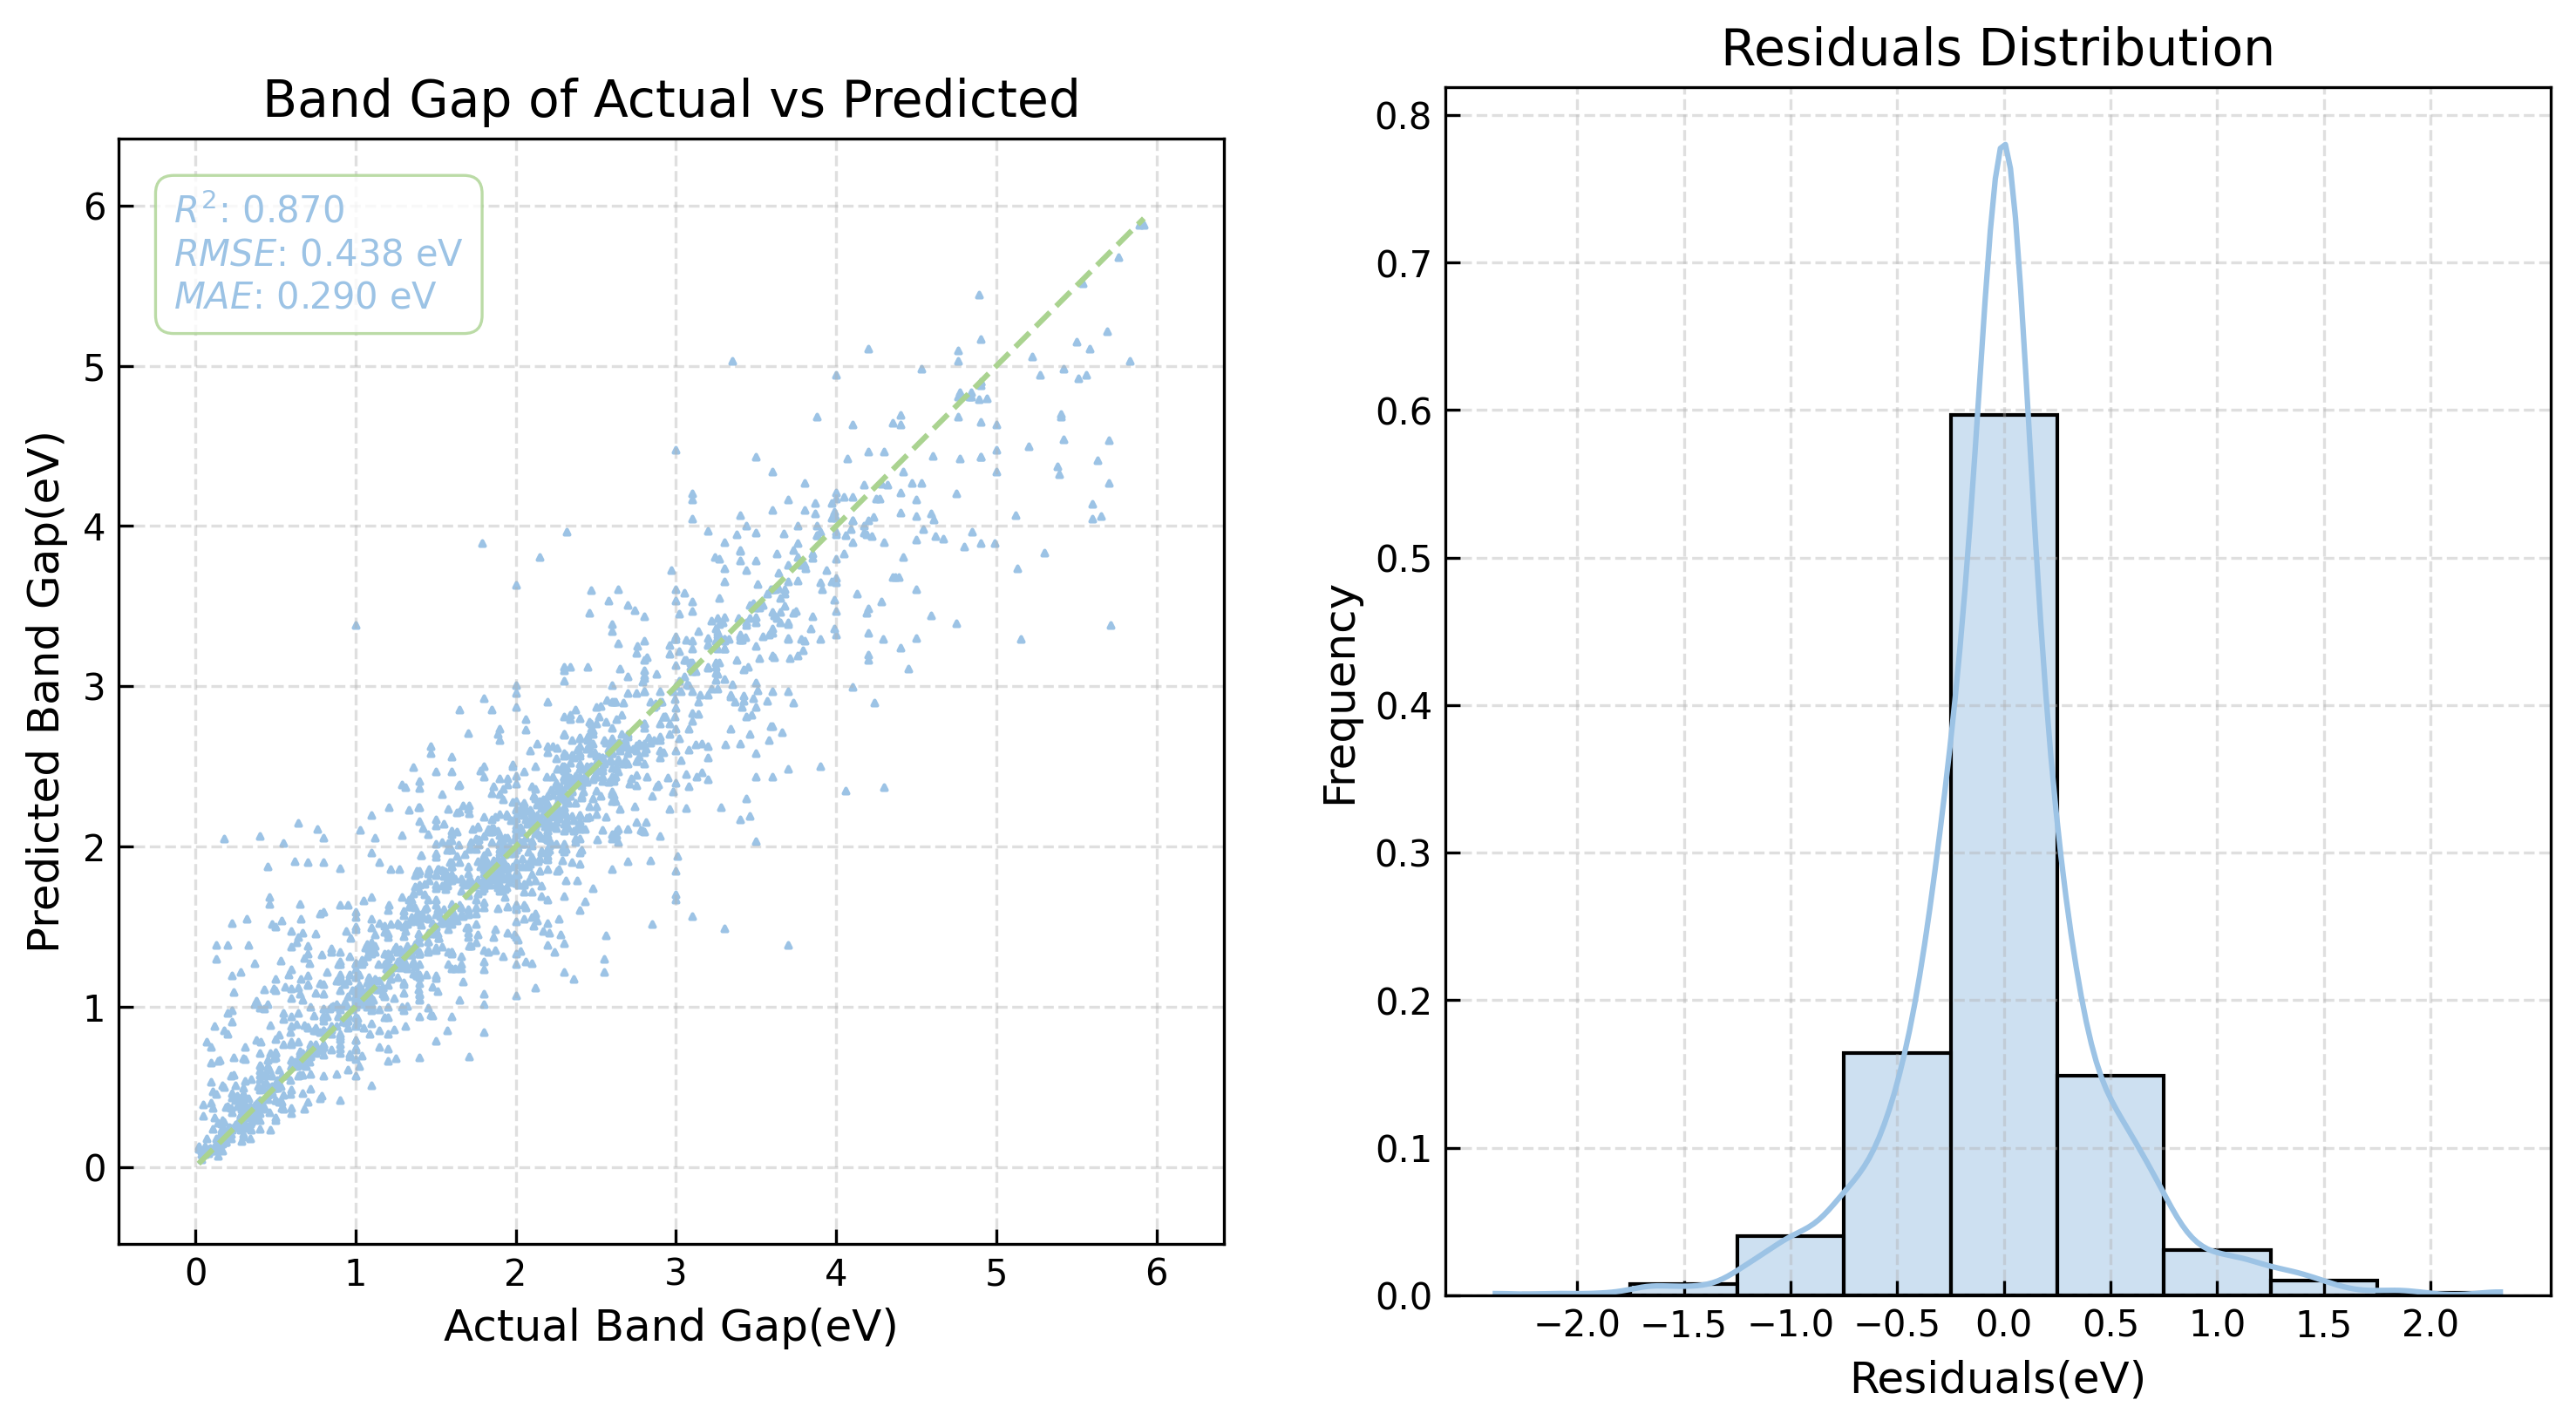


Model Evaluation Results:
Test set: R²: 0.8696 RMSE: 0.4382 MAE: 0.2903
[Test EXP -> EXP] Evaluating EXP KNN on EXP test set:


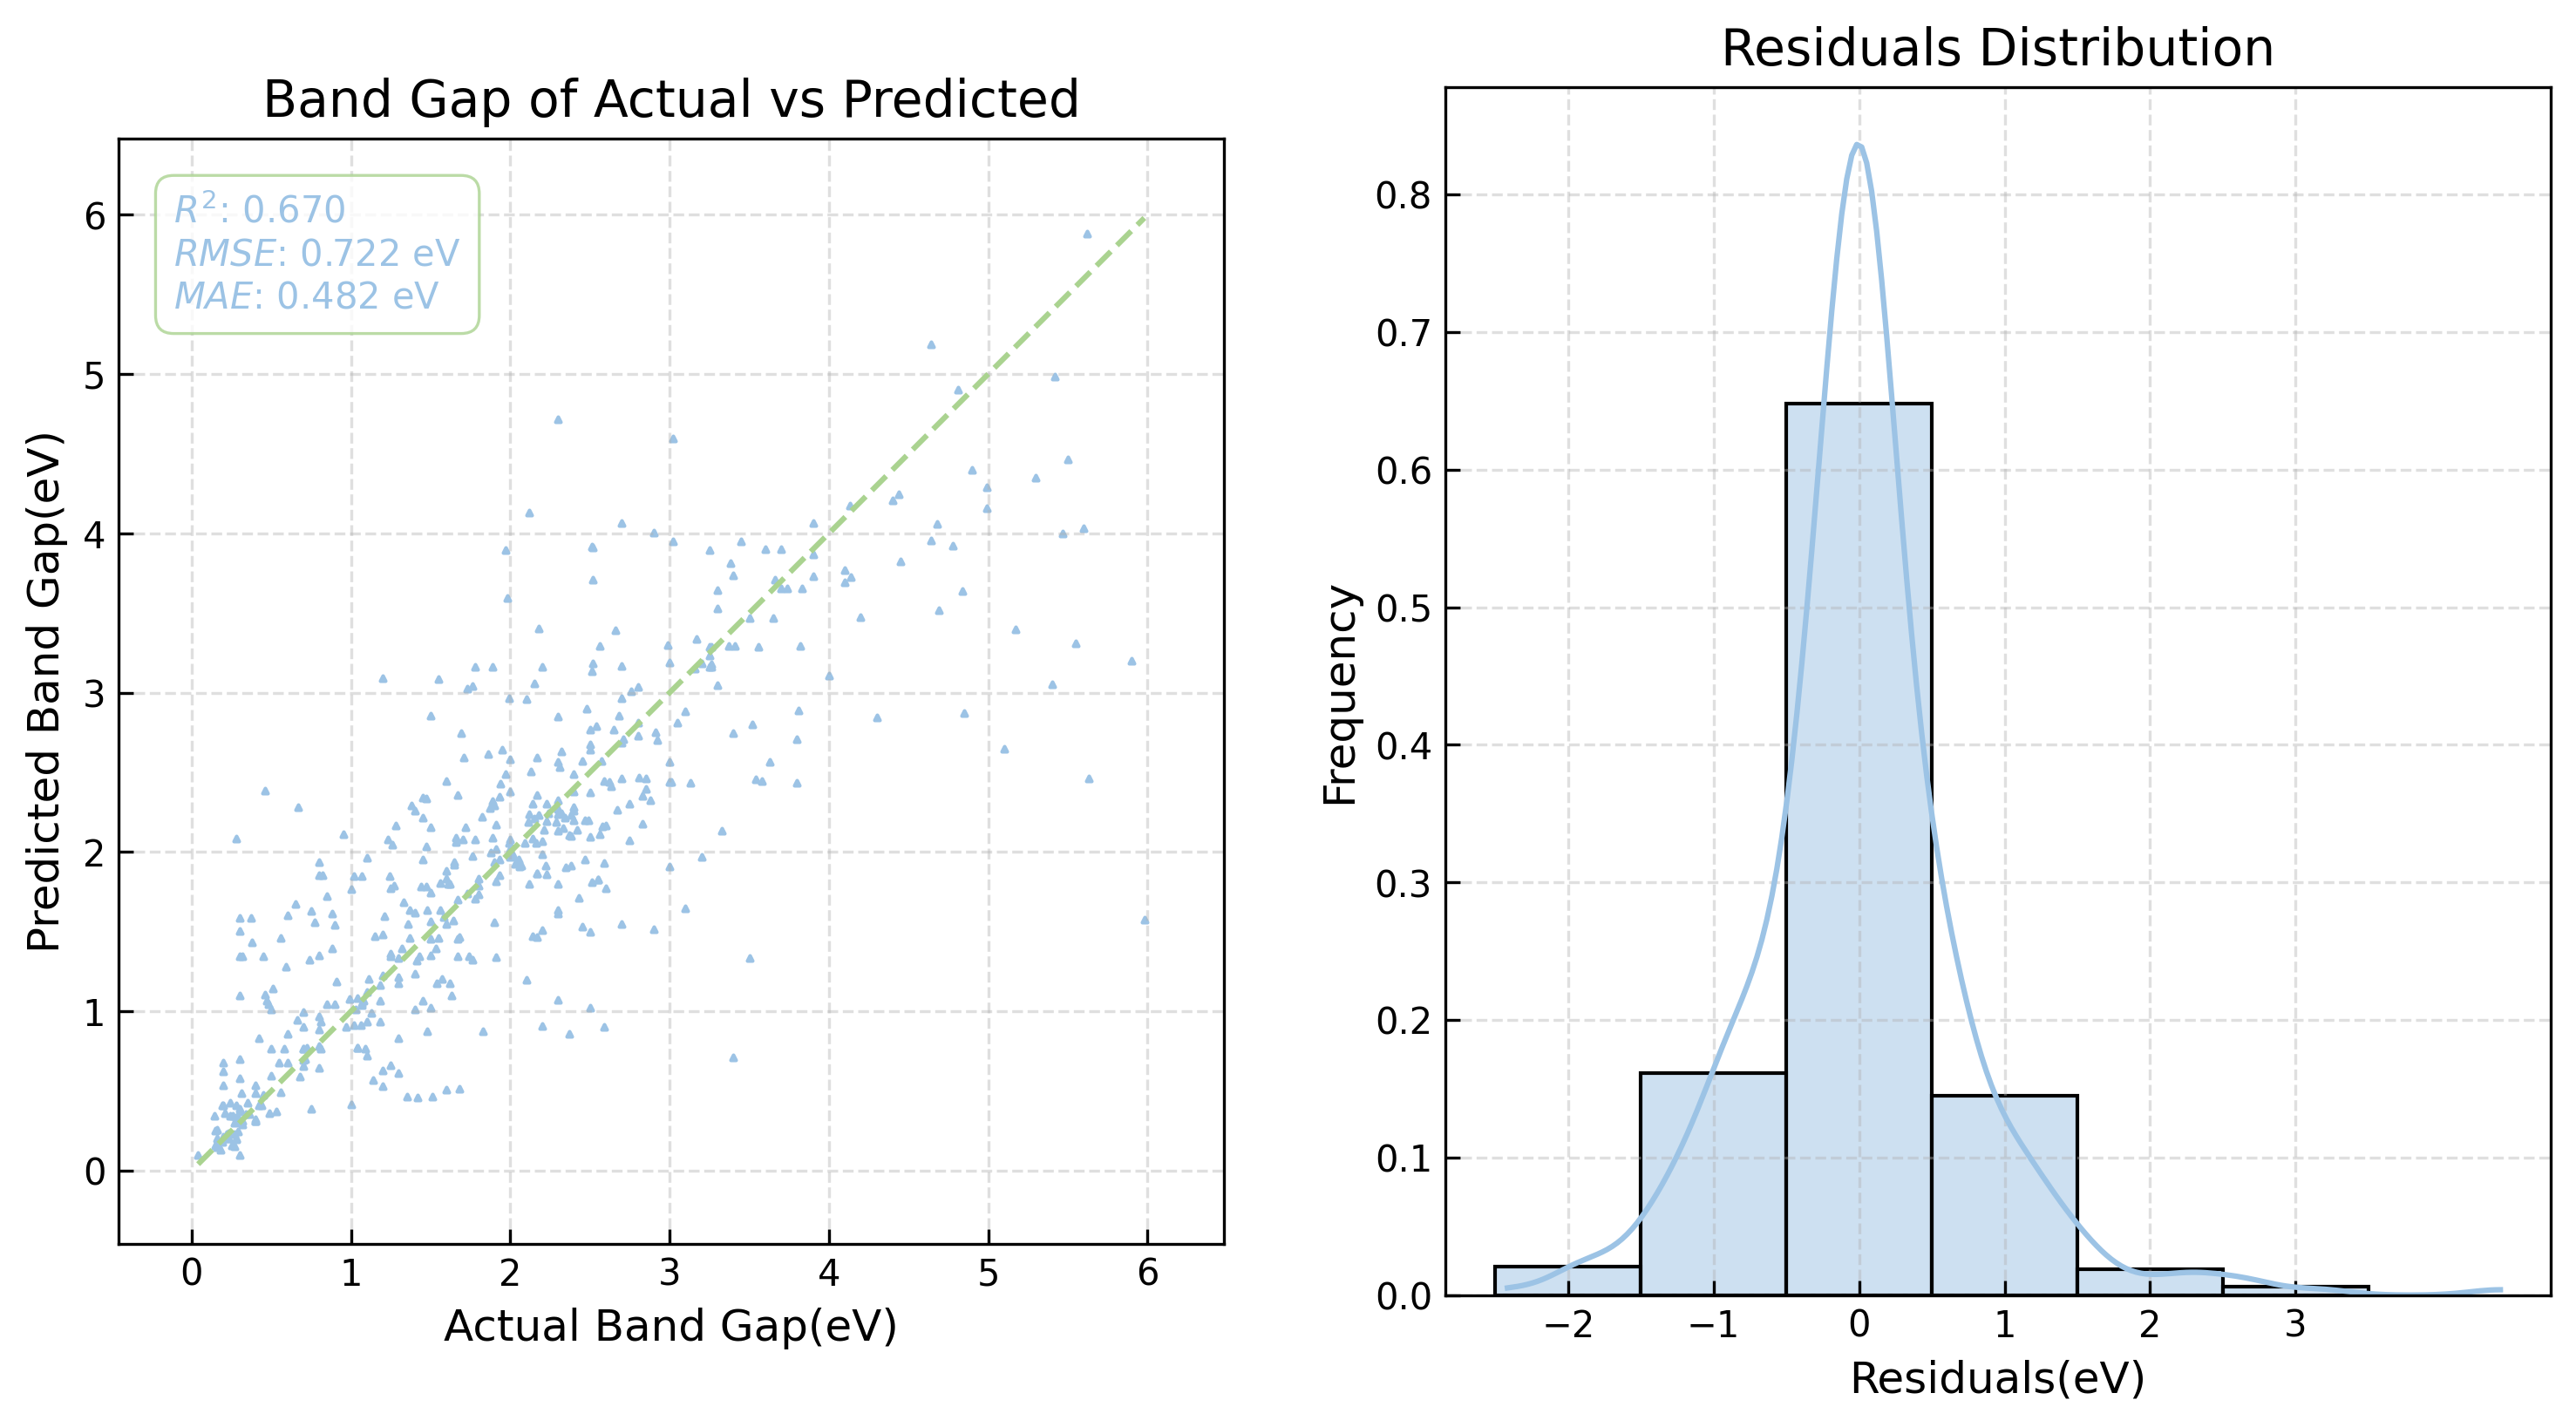


Model Evaluation Results:
Test set: R²: 0.6703 RMSE: 0.7216 MAE: 0.4822
[Test EXP -> DFT] Evaluating EXP KNN on DFT test set:


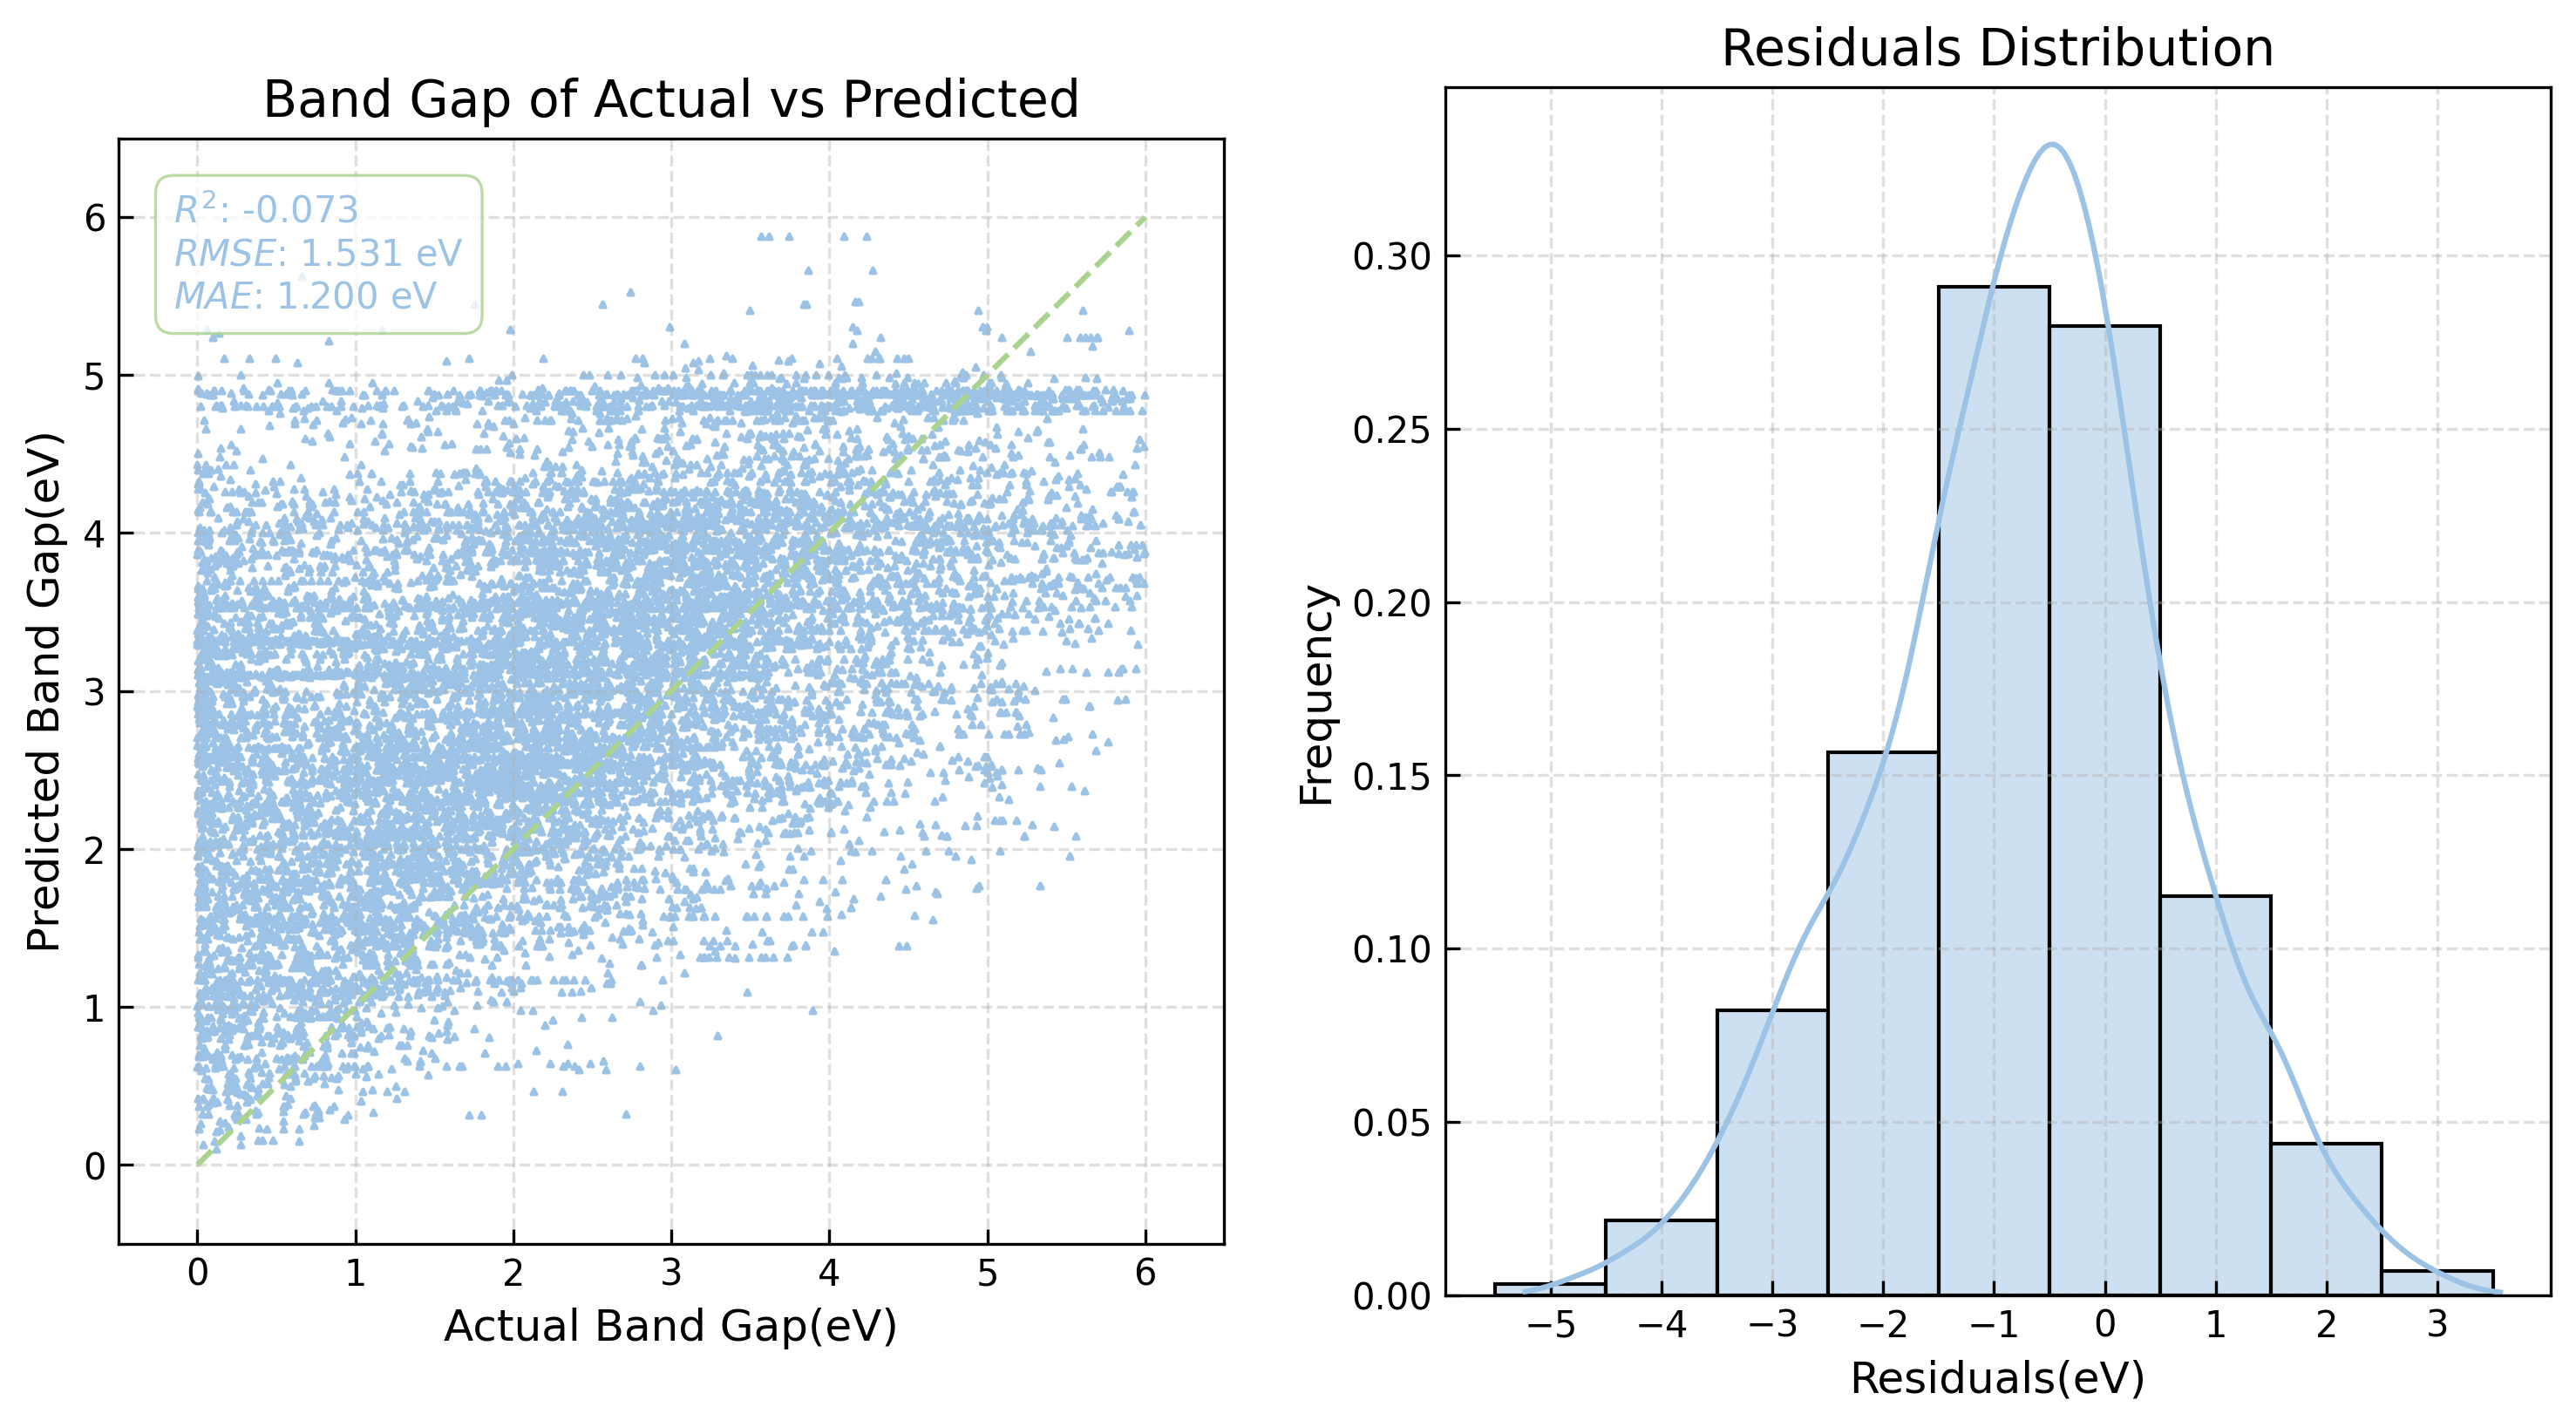


Model Evaluation Results:
Test set: R²: -0.0731 RMSE: 1.5312 MAE: 1.1999


In [39]:

# 
# Train the model with the best hyperparameters on the entire training set
knn_best = KNeighborsRegressor(n_neighbors=3, weights='uniform', p=1, metric='manhattan', n_jobs=-1)

# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(knn_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [40]:
model_metrics.head()

Model Error_Type Train_set Test_set        R²      RMSE       MAE
0   KNN      Train       exp      exp  0.869587  0.438170  0.290281
1   KNN       Test       exp      exp  0.670314  0.721564  0.482190
2   KNN       Test       exp      dft -0.073070  1.531182  1.199863